<div class="markdown-google-sans">

## **Introduction**
</div>

It is crucial to constantly bear in mind the problem we aim to solve when utilizing Machine Learning algorithms. While accuracy and robustness are often the desired qualities of a model, there are occasions where we must derive insights from the data at hand. In such cases, transparent and easily interpretable models like Decision Trees can significantly streamline our analysis.

<div class="markdown-google-sans">

## **Preparing the Titanic dataset**
</div>

Our objective is to predict whether individuals in the test dataset survived the shipwreck or not. However, for our current analysis, we will also utilize a Classification Tree to gain insights about the disaster. Let's load the data and gain a general understanding.

In [10]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

train = pd.read_csv('https://raw.githubusercontent.com/DrAdamRoe/prob-stats-class/main/Week05/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/DrAdamRoe/prob-stats-class/main/Week05/test.csv')

PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


Based on this overview, it is evident that our dataset requires some preprocessing. While the Survived class is already in binary format, features such as Name, Ticket, and Cabin must be modified to suit our problem. Furthermore, we can engineer new features by merging or grouping existing ones.

In [11]:
# Copy original dataset in case we need it later when digging into interesting features
original_train = train.copy() # Using 'copy()' allows to clone the dataset, creating a different object with the same values

full_data = [train, test]

# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

# Remove all NULLS in the Fare column
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

# Remove all NULLS in the Age column
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    # Next line has been improved to avoid warning
    dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace(['Mlle', 'Ms'], 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] ;

In [12]:
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements, axis = 1)

<div class="markdown-google-sans">

## **Visualising processed data**
</div>


In [13]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,0,2,0,1
1,1,1,0,2,0,3,1,1,2,0,3
2,1,3,0,1,0,1,0,0,1,1,4


After preprocessing, our dataset has become significantly cleaner and more useful, consisting of only numerical values and potentially meaningful features.

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

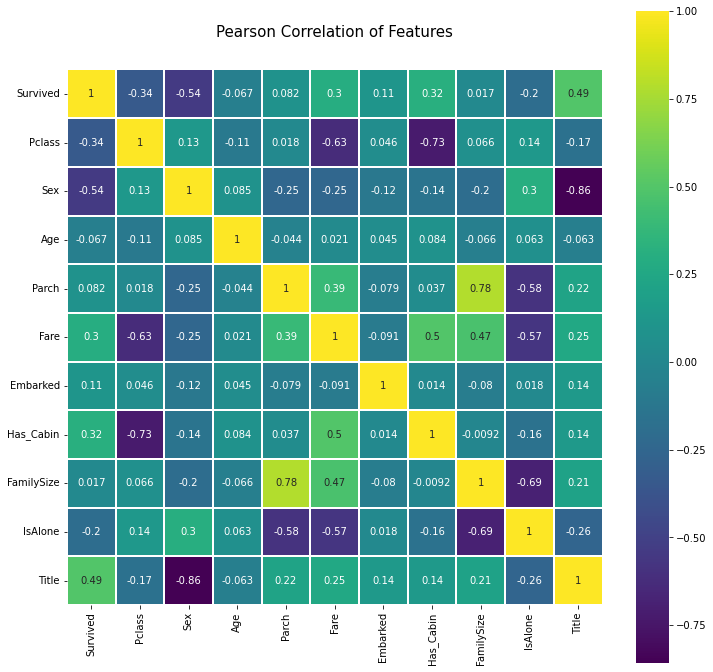

In [14]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

This heatmap is a valuable initial observation as it provides insight into the predictive value of each feature. In this instance, Sex and Title exhibit the strongest correlations (in absolute terms) with the Survived class, at 0.54 and 0.49, respectively. However, their absolute correlation is also quite high at 0.86, the greatest in our dataset. As a result, they are likely conveying the same information, and employing both as inputs for the same model would not be prudent. It is probable that one of them will serve as the first node in our final decision tree, so let us examine these features in more depth and compare them.

In [15]:
train[['Title', 'Survived']].groupby(['Title'], as_index=False).agg(['mean', 'count', 'sum'])
# Since "Survived" is a binary class (0 or 1), these metrics grouped by the Title feature represent:
    # MEAN: survival rate
    # COUNT: total observations
    # SUM: people survived

# title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5} 

Survived           
           mean count  sum
Title                     
1      0.156673   517   81
2      0.575000    40   23
3      0.793651   126  100
4      0.702703   185  130
5      0.347826    23    8

In [16]:
train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).agg(['mean', 'count', 'sum'])
# Since Survived is a binary feature, this metrics grouped by the Sex feature represent:
    # MEAN: survival rate
    # COUNT: total observations
    # SUM: people survived
    
# sex_mapping = {{'female': 0, 'male': 1}} 

Survived           
         mean count  sum
Sex                     
0    0.742038   314  233
1    0.188908   577  109

The data shows that less 'Mr' survived (15,67%) than men in general (18.89%): Title seems therefore to be more useful than Sex for our purpose. This may be because Title implicitly includes information about Sex in most cases. To verify this, we can use the copy we made of the original training data without mappings and check the distribution of Sex grouped by Title.

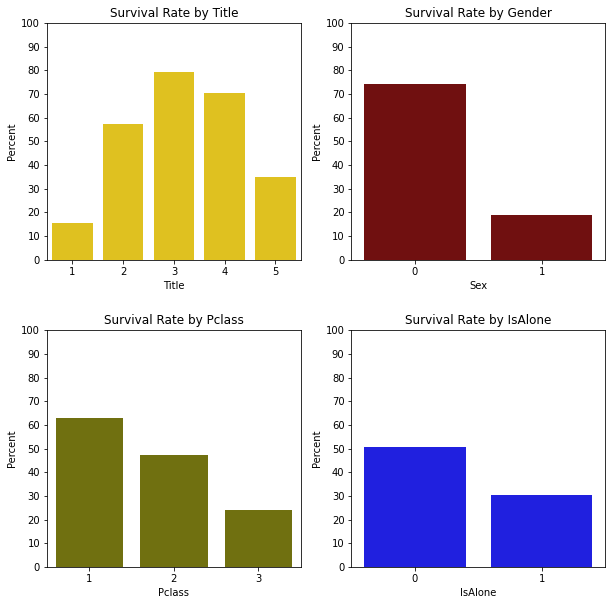

In [17]:
def plot_survival_rate(data, x_col, y_col, title, color, ax):
    survival_rate = data.groupby(x_col)[y_col].value_counts(normalize=True).unstack()
    survival_rate = survival_rate[1]
    sns.barplot(x=survival_rate.index, y=survival_rate.values, color=color, ax=ax)
    ax.set_title(title)
    ax.set_yticks(ticks=np.arange(0,1.1,0.1), labels=np.arange(0,110,10))
    ax.set_ylabel('Percent')

fig, axs = plt.subplots(2,2,figsize=(10,10))
plot_survival_rate(train, 'Title', 'Survived', 'Survival Rate by Title', 'gold', axs[0,0]) #Women: 0, Men: 1
plot_survival_rate(train, 'Sex', 'Survived', 'Survival Rate by Gender', 'maroon', axs[0,1])
plot_survival_rate(train, 'Pclass', 'Survived', 'Survival Rate by Pclass', 'olive', axs[1,0])
plot_survival_rate(train, 'IsAlone', 'Survived', 'Survival Rate by IsAlone', 'blue', axs[1,1])
plt.subplots_adjust(hspace=0.3)
plt.show()

<div class="markdown-google-sans">

## **Finding best tree depth with the help of Cross Validation** ##
</div>

After exploring the data, we're going to find of much of it can be relevant for our decision tree. This is a critical point for every Data Science project, since too much train data can easily result in bad model generalisation (accuracy on test/real/unseen observations). Over-fitting (a model excessively adapted to the train data) is a common reason. In other cases, too much data can also hide meaningful relationships either because they evolve with time or because highly correlated features prevent the model from capturing properly the value of each single one.

In [18]:
cv = KFold(n_splits=10)            # Desired number of Cross Validation folds
accuracies = list()
max_attributes = len(list(test))
depth_range = range(1, max_attributes + 1)

# Testing max_depths from 1 to max attributes
# Uncomment prints for details about each Cross Validation pass
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(max_depth = depth)
    # print("Current max depth: ", depth, "\n")
    for train_fold, valid_fold in cv.split(train):
        f_train = train.loc[train_fold] # Extract train data with cv indices
        f_valid = train.loc[valid_fold] # Extract valid data with cv indices

        model = tree_model.fit(X = f_train.drop(['Survived'], axis=1), 
                               y = f_train["Survived"]) # We fit the model with the fold train data
        valid_acc = model.score(X = f_valid.drop(['Survived'], axis=1), 
                                y = f_valid["Survived"])# We calculate accuracy with the fold validation data
        fold_accuracy.append(valid_acc)

    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    # print("Accuracy per fold: ", fold_accuracy, "\n")
    # print("Average accuracy: ", avg)
    # print("\n")
    
# Just to show results conveniently
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.782285
         2          0.799189
         3          0.828277
         4          0.819288
         5          0.815943
         6          0.804769
         7          0.808102
         8          0.809238
         9          0.815980
        10          0.809238


It appears that the optimal max_depth parameter is 3, as indicated by the average accuracy of 82.8% across the ten folds. Using more data appears to yield poorer results, most likely due to overfitting. Therefore, we will employ a max_depth parameter of 3 for our final model.

<div class="markdown-google-sans">

## **Final Tree** ##
</div>


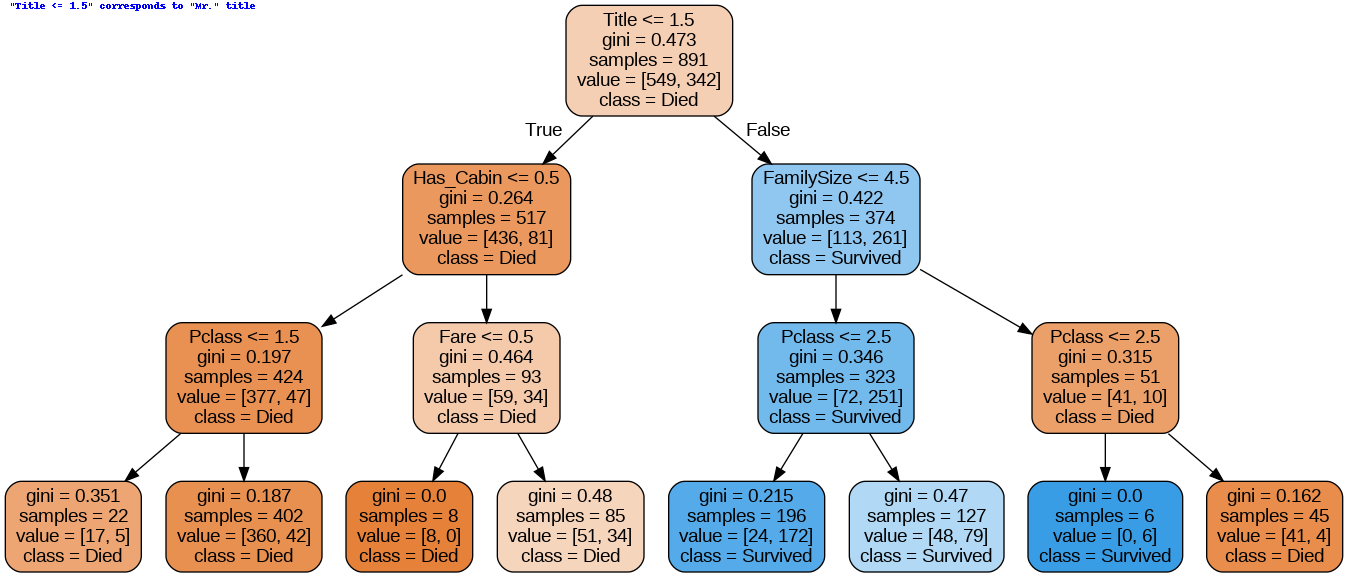

In [19]:
# Create Numpy arrays of train, test and target (Survived) dataframes to feed into our models
y_train = train['Survived']
x_train = train.drop(['Survived'], axis=1).values 
x_test = test.values

# Create Decision Tree with max_depth = 3
decision_tree = tree.DecisionTreeClassifier(max_depth = 3)
decision_tree.fit(x_train, y_train)

# Predicting results for test dataset
y_pred = decision_tree.predict(x_test)
submission = pd.DataFrame({
        "PassengerId": PassengerId,
        "Survived": y_pred
    })
submission.to_csv('submission.csv', index=False)

# Export our trained model as a .dot file
with open("tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 3,
                              impurity = True,
                              feature_names = list(train.drop(['Survived'], axis=1)),
                              class_names = ['Died', 'Survived'],
                              rounded = True,
                              filled= True )
        
#Convert .dot to .png to allow display in web notebook
check_call(['dot','-Tpng','tree1.dot','-o','tree1.png'])

# Annotating chart with PIL
img = Image.open("tree1.png")
draw = ImageDraw.Draw(img)
draw.text((10, 0), # Drawing offset (position)
          '"Title <= 1.5" corresponds to "Mr." title', # Text to draw
          (0,0,255)) # ImageFont object with desired font
img.save('sample-out.png')
PImage("sample-out.png")

In [20]:
acc_decision_tree = round(decision_tree.score(x_train, y_train) * 100, 2)
acc_decision_tree

82.38

Finally, here we have our Decision Tree! It achieves an accuracy of 82.38% across the training dataset. Let's begin explaining how to read the graph.

The first line of each node (except those of the final row) shows the splitting condition in the form "feature <= value".

"Value" shows the class distribution of the samples ([count non_survived, count survived]).

Lastly, "class" correspond to the predominant class of each node, and this is how our model will classify an observation. The colour also represents the class, the opacity increasing with the actual distribution of samples.


Our model can therefore be summarised with 4 simple rules:

    If our observation includes de "Mr" Title, then we classify it as not survived (all the branches in the left side of the tree lead to an orange node)
    If it doesn't include "Mr" Title, and FamilySize is 4 or less, then we classify it as survived.
    If it doesn't include "Mr" Title, FamilySize is more than 4 and Pclass is 2 or less, then we classify it as survived.
    If it doesn't include "Mr" Title, FamilySize is more than 4 and Pclass is more than 2, then we classify it as not survived.
